# Cross-Correlation

In [1]:
import os
import sys
from pathlib import Path

repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

from pipeline import harmony
from harmonia.algorithms import DiscreteSpectrum

plt.style.use(harmony)

In [3]:
case = 'full-sky'  # 'partial-sky'

if case == 'full-sky':
    info = "mask=1.0,selection=None"
if case == 'partial-sky':
    info = "mask=random0_BOSS_DR12v5_CMASS_North,selection=[100.0,500.0]"

In [4]:
storage = repo_root/"storage"/"processed"/"survey_products"

cross_corr = np.load(
    storage/
    "covar-estimate-(source=1-2500,map=cross,boxsize=1000.0,scale=[None,0.04,0.09],orders=[0],{}).npy".format(info)
)[-4:, :-4]

cart_wavenumbers = np.load(
    storage/
    "covar-estimate-(source=1-2500,map=cartesian,boxsize=1000.0,scale=[0.04,0.09],orders=[0],{}).npz".format(info)
)['wavenumbers']

In [5]:
disc = DiscreteSpectrum(500., 'd', 0.04)

[2020-07-24 14:47:44 (+0:00:00) INFO] DiscreteSpectrum(dirichlet, boundary=500.0, 0.0<=wavenumber<=0.04) computed: 15 degrees and 456 modes in total.


In [6]:
sphr_indices = [
    (ell, m, n) 
    for ell, nmax in zip(disc.degrees, disc.depths) 
    for m in range(- ell, ell + 1)
    for n in range(1, nmax + 1)
]

sphr_wavenumbers = sorted(disc.wavenumbers.values())

cross_corr_bins = [
    [[] for k_ln in sphr_wavenumbers] 
    for k_i in cart_wavenumbers
]
for i_k in range(len(cart_wavenumbers)):
    for j_lmn, (ell, _, n) in enumerate(sphr_indices):
        j_ln = sphr_wavenumbers.index(disc.wavenumbers[(ell, n)])
        cross_corr_bins[i_k][j_ln].append(cross_corr[i_k, j_lmn])        

In [7]:
cross_corr_avg = [
    [np.mean(np.abs(cross_corr_bins[i_k][j_ln])) for j_ln in range(len(sphr_wavenumbers))]
    for i_k in range(len(cart_wavenumbers))    
]

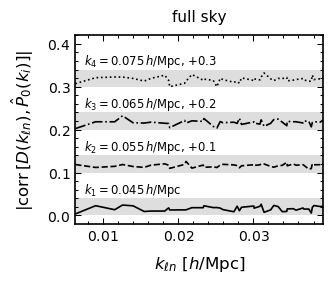

In [8]:
linestyles = ['-', '--', '-.', ':']
width = 0.04 if case == 'full-sky' else 0.06
shifts = np.arange(0., 0.5, 0.1)

fig = plt.figure(figsize=(3.2, 2.5), dpi=100)

ax = plt.subplot(111)

for bin_index, (cross_corr, k_i, yshift, ls) in enumerate(
        zip(cross_corr_avg, cart_wavenumbers, shifts, linestyles)
    ):
    ax.plot(
        sphr_wavenumbers, np.abs(cross_corr) + yshift,
        ls=ls, c='k',
        label=(
            None if bin_index > 1
            else r"$k_{} = {:.3f}\,h/\mathrm{{Mpc}}$".format(bin_index + 1, k_i, yshift)
        )
    )
    ax.axhspan(yshift, yshift + width, fc='0.75', ec='none', alpha=0.5)
    if case == 'full-sky':
        ax.text(
            0.0075, yshift + 0.06,
            r"$k_{} = {:.3f}\,h/\mathrm{{Mpc}}$, +{:.1f}".format(bin_index + 1, k_i, yshift).strip(", +0.0"),
            va='center', fontsize='small'
        )
    
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(sphr_wavenumbers[0], sphr_wavenumbers[-1]);
ax.set_ylim(-0.02, 0.42);
ax.set_xlabel(r"$k_{\ell n}$ [$h$/Mpc]", labelpad=8);
ax.set_ylabel(
    r"$\vert{\operatorname{corr}}\,[D(k_{\ell n}), \hat{P}_0(k_i)]\vert$", labelpad=8
);
ax.set_title(case.replace("-", " "), pad=10, fontsize=11)

fig.savefig(repo_root/"notebooks"/"publications"/"cross_correlation_{}.pdf".format(case))

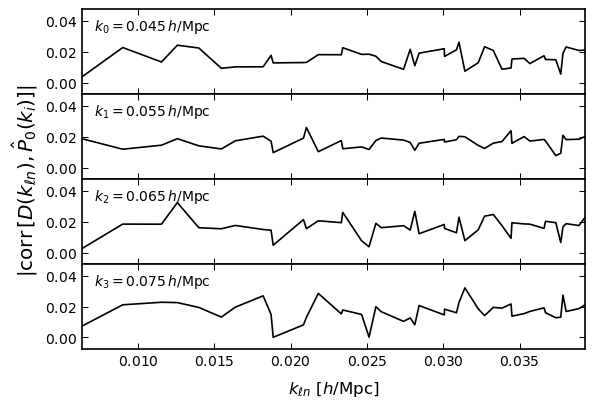

In [9]:
fig, axes = plt.subplots(len(cart_wavenumbers), 1, sharex=True, squeeze=True, figsize=(6.5, 4.5), dpi=100)

for bin_index, (ax, cross_corr, k_i) in enumerate(zip(axes, cross_corr_avg, cart_wavenumbers)):
    ax.plot(sphr_wavenumbers, np.abs(cross_corr))
    ax.text(
        0.025, 0.8,
        r"$k_{} = {:.3f}\,h/\mathrm{{Mpc}}$".format(bin_index, k_i), 
        transform=ax.transAxes, va='center'
    )
    ax.set_ylim(-0.0075, 0.0475)

ax.set_xlim(sphr_wavenumbers[0], sphr_wavenumbers[-1]);
ax.set_xlabel(r"$k_{\ell n}$ [$h$/Mpc]", labelpad=8);

fig.text(
    0.015, 0.5, r"$\vert{\operatorname{corr}}\,[D(k_{\ell n}), \hat{P}_0(k_i)]\vert$",
    fontsize='x-large',
    va='center', rotation='vertical'
);
# fig.savefig(repo_root/"notebooks"/"publications"/"cross_correlations_{}.pdf".format(case))